In [2]:
import cv2
import numpy as np
import supervision as sv
from inference import get_model
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from dataclasses import dataclass, field
from typing import List, Tuple
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Define ViewTransformer class (same as before)
class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        if source.shape != target.shape:
            raise ValueError("Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError("Source and target points must be 2D coordinates.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m, _ = cv2.findHomography(source, target)
        if self.m is None:
            raise ValueError("Homography matrix could not be calculated.")

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)


# Define SoccerPitchConfiguration class
class SoccerPitchConfiguration:
    width: int = 7000  # [cm]
    length: int = 12000  # [cm]
    penalty_box_width: int = 4100  # [cm]
    penalty_box_length: int = 2015  # [cm]
    goal_box_width: int = 1832  # [cm]
    goal_box_length: int = 550  # [cm]
    centre_circle_radius: int = 915  # [cm]
    penalty_spot_distance: int = 1100  # [cm]

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        return [
            (0, 0),  # 1
            (0, (self.width - self.penalty_box_width) / 2),  # 2
            (0, (self.width - self.goal_box_width) / 2),  # 3
            (0, (self.width + self.goal_box_width) / 2),  # 4
            (0, (self.width + self.penalty_box_width) / 2),  # 5
            (0, self.width),  # 6
            (self.goal_box_length, (self.width - self.goal_box_width) / 2),  # 7
            (self.goal_box_length, (self.width + self.goal_box_width) / 2),  # 8
            (self.penalty_spot_distance, self.width / 2),  # 9
            (self.penalty_box_length, (self.width - self.penalty_box_width) / 2),  # 10
            (self.penalty_box_length, (self.width - self.goal_box_width) / 2),  # 11
            (self.penalty_box_length, (self.width + self.goal_box_width) / 2),  # 12
            (self.penalty_box_length, (self.width + self.penalty_box_width) / 2),  # 13
            (self.length / 2, 0),  # 14
            (self.length / 2, self.width / 2 - self.centre_circle_radius),  # 15
            (self.length / 2, self.width / 2 + self.centre_circle_radius),  # 16
            (self.length / 2, self.width),  # 17
            (
                self.length - self.penalty_box_length,
                (self.width - self.penalty_box_width) / 2
            ),  # 18
            (
                self.length - self.penalty_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 19
            (
                self.length - self.penalty_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 20
            (
                self.length - self.penalty_box_length,
                (self.width + self.penalty_box_width) / 2
            ),  # 21
            (self.length - self.penalty_spot_distance, self.width / 2),  # 22
            (
                self.length - self.goal_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 23
            (
                self.length - self.goal_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 24
            (self.length, 0),  # 25
            (self.length, (self.width - self.penalty_box_width) / 2),  # 26
            (self.length, (self.width - self.goal_box_width) / 2),  # 27
            (self.length, (self.width + self.goal_box_width) / 2),  # 28
            (self.length, (self.width + self.penalty_box_width) / 2),  # 29
            (self.length, self.width),  # 30
            (self.length / 2 - self.centre_circle_radius, self.width / 2),  # 31
            (self.length / 2 + self.centre_circle_radius, self.width / 2),  # 32
        ]

    edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (7, 8),
        (10, 11), (11, 12), (12, 13), (14, 15), (15, 16),
        (16, 17), (18, 19), (19, 20), (20, 21), (23, 24),
        (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
        (1, 14), (2, 10), (3, 7), (4, 8), (5, 13), (6, 17),
        (14, 25), (18, 26), (23, 27), (24, 28), (21, 29), (17, 30)
    ])

    labels: List[str] = field(default_factory=lambda: [
        "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
        "11", "12", "13", "15", "16", "17", "18", "20", "21", "22",
        "23", "24", "25", "26", "27", "28", "29", "30", "31", "32",
        "14", "19"
    ])

    colors: List[str] = field(default_factory=lambda: [
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#00BFFF", "#00BFFF", "#00BFFF", "#00BFFF", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#00BFFF", "#00BFFF"
    ])

# Load models
pitch_detection_model = get_model(
    model_id="football-field-detection-f07vi/14", 
    api_key="Syif8Lk5HpfBpj57aXEy"
)

player_detection_model = get_model(
    model_id="football-players-detection-3zvbc/10", 
    api_key="Syif8Lk5HpfBpj57aXEy"
)


# Load image
image_path = "Shot1.jpg"
frame = cv2.imread(image_path)

# Detect pitch
pitch_result = pitch_detection_model.infer(frame, confidence=0.3)[0]
pitch_keypoints = sv.KeyPoints.from_inference(pitch_result)

# Filter keypoints
filter = pitch_keypoints.confidence[0] > 0.5
pitch_keypoints.xy = pitch_keypoints.xy[0][filter][np.newaxis]
pitch_keypoints.confidence = pitch_keypoints.confidence[0][filter][np.newaxis]

# Detect players
player_result = player_detection_model.infer(frame, confidence=0.3)[0]
player_detections = sv.Detections.from_inference(player_result)

# Transform player coordinates
CONFIG = SoccerPitchConfiguration()
transformer = ViewTransformer(
    source=pitch_keypoints.xy[0].astype(np.float32),
    target=np.array(CONFIG.vertices)[filter].astype(np.float32)
)

player_xy = player_detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
transformed_xy = transformer.transform_points(points=player_xy)

# Function to calculate distance to goal
def distance_to_goal(x, y):
    goal_center_x = CONFIG.length
    goal_center_y = CONFIG.width / 2
    return np.sqrt((x - goal_center_x)**2 + (y - goal_center_y)**2)

# Function to calculate angle to goal
def angle_to_goal(x, y):
    goal_center_x = CONFIG.length
    goal_center_y = CONFIG.width / 2
    dx = goal_center_x - x
    dy = goal_center_y - y
    angle = np.abs(np.arctan2(dy, dx))
    return angle

[09/15/24 19:36:30] WARNING  Your inference package version 0.15.2 is out of date! Please upgrade to ]8;id=752433;file://c:\Users\Miguel\AppData\Local\Programs\Python\Python311\Lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=290070;file://c:\Users\Miguel\AppData\Local\Programs\Python\Python311\Lib\site-packages\inference\core\__init__.py#35\35]8;;\
                             version 0.18.1 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, FontManager
from mplsoccer import Sbopen

pd.set_option('display.max_columns', 500)



parser = Sbopen()
df_match = parser.match(competition_id=43, season_id=106)
df_matches = {}
for i, id in enumerate(df_match['match_id']):
  df_matches[id] = {}
  df_matches[id]['event'], df_matches[id]['related'], df_matches[id]['freeze'], df_matches[id]['tactic'] = parser.event(id)

In [4]:
# we'll take the location, outcome, and also the xG by Statsbomb to compare it to our model later
df_shot = pd.DataFrame(columns=['x', 'y', 'outcome_name', 'shot_statsbomb_xg'])

for id in df_match['match_id']:
  # we take the period <= 4 because statsbomb also record penalty shots in the penalty shoot-out stage, we won't be using those shots
  # for our first model, we'll only take open play shots because penalty shots tend to have way higher goal probability
  # we'll use the other shots scenario in our next model
  mask_shot = (df_matches[id]['event'].type_name == 'Shot') & (df_matches[id]['event'].period	<= 4) & (df_matches[id]['event'].sub_type_name	== 'Open Play')
  shots_temp = df_matches[id]['event'].loc[mask_shot, ['x', 'y', 'outcome_name', 'shot_statsbomb_xg']]
  df_shot = pd.concat([df_shot, shots_temp]).reset_index(drop=True)

In [5]:
import math

def calculate_angle(x, y):
  # 44 and 36 is the location of each goal post
  g0 = [120, 44]
  p = [x, y]
  g1 = [120, 36]

  v0 = np.array(g0) - np.array(p)
  v1 = np.array(g1) - np.array(p)

  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
  return(abs(np.degrees(angle)))

def calculate_distance(x, y):
  x_dist = 120-x
  y_dist = 0
  if (y<36):
    y_dist = 36-y
  elif (y>44):
    y_dist = y-44
  return math.sqrt(x_dist**2 + y_dist**2)

In [6]:
df_shot['angle'] = df_shot.apply(lambda row:calculate_angle(row['x'], row['y']), axis=1)
df_shot['distance'] = df_shot.apply(lambda row:calculate_distance(row['x'], row['y']), axis=1)
# we'll create new column to define goal or not
df_shot['goal'] = df_shot.apply(lambda row:1 if row['outcome_name']=='Goal' else 0, axis=1)

In [18]:
# Group by Goal then show mean Angle and Distance
goal_stats = df_shot.groupby('goal').agg({
    'angle': 'mean',
    'distance': 'mean'
})

print(goal_stats)


          angle   distance
goal                      
0     24.603812  17.339943
1     40.928138  10.902455


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

model_names = ['Linear', 'Logistic']
models = {}
models['Linear'] = {}
models['Linear']['model'] = LinearRegression()
models['Logistic'] = {}
models['Logistic']['model'] = LogisticRegression()

In [9]:
X = df_shot[['angle', 'distance']]
y = df_shot['goal']

from sklearn import metrics
for mod in model_names:
  models[mod]['model'].fit(X, y)
  if mod == 'Logistic':
    models[mod]['y_pred'] = models[mod]['model'].predict_proba(X)[:, 1]
  else:
    models[mod]['y_pred'] = models[mod]['model'].predict(X)

  models[mod]['r2_score'] = metrics.r2_score(y, models[mod]['y_pred'])
  print("R2 of model {}: {}".format(mod, models[mod]['r2_score']))

R2 of model Linear: 0.09901547697233781


R2 of model Logistic: 0.09565489627052592


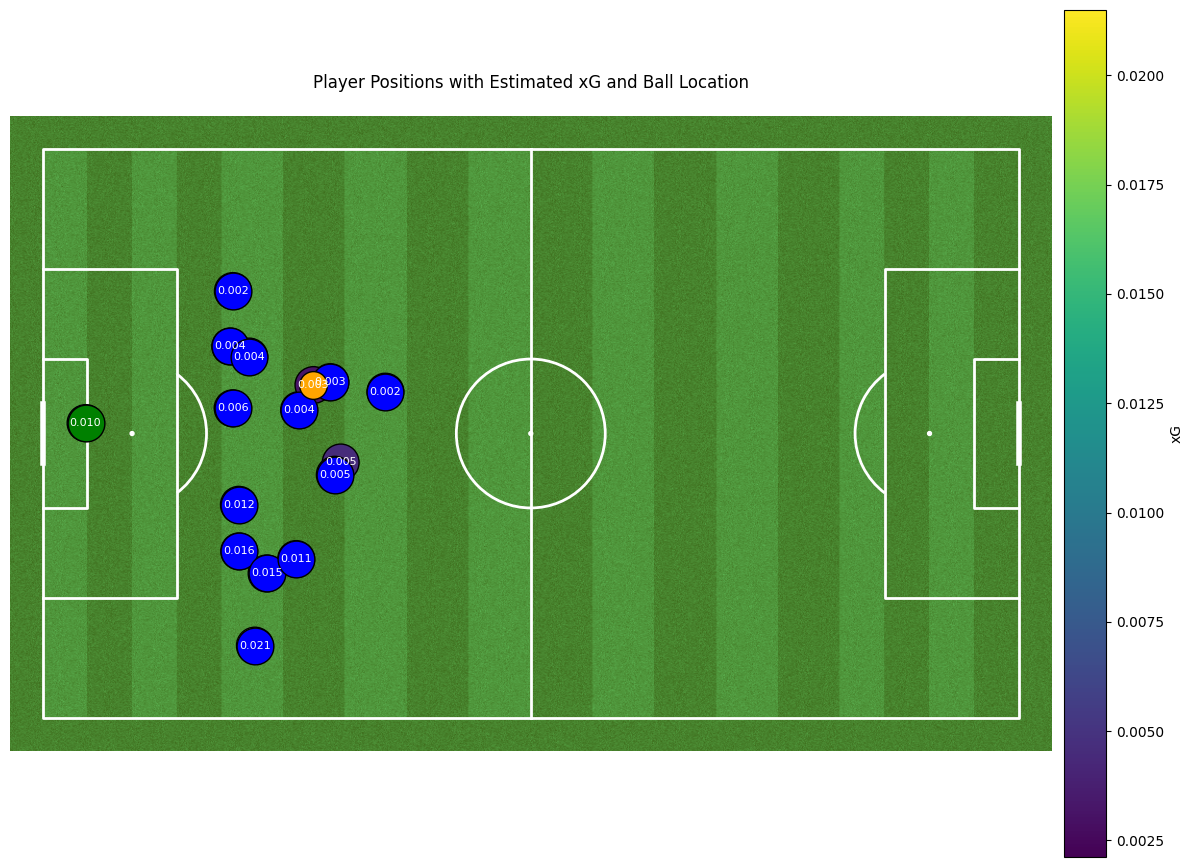

Player 1 xG: 0.004
Player 2 xG: 0.002
Player 3 xG: 0.003
Player 4 xG: 0.006
Player 5 xG: 0.016
Player 6 xG: 0.015
Player 7 xG: 0.011
Player 8 xG: 0.012
Player 10 xG: 0.002
Goalkeeper xG: 0.010
Player 12 xG: 0.004
Player 13 xG: 0.005
Player 14 xG: 0.004
Ball xG: 0.003
Player 16 xG: 0.021


In [19]:
# Function to load and train the xG model
def load_xg_model():
    # Use the existing df_shot DataFrame
    X = df_shot[['distance', 'angle']]
    y = df_shot['goal']
    
    model = LogisticRegression()
    model.fit(X, y)
    
    return model

xg_model = load_xg_model()

# Function to calculate xG using the loaded model
def calculate_xg(distance, angle):
    return xg_model.predict_proba([[distance, angle]])[0][1]

# Calculate xG for each player
xg_values = []
for x, y in transformed_xy:
    # Convert coordinates from cm to meters for consistency
    distance = distance_to_goal(x, y) / 100  # Convert to meters
    angle = angle_to_goal(x, y)
    xg = calculate_xg(distance, angle)
    xg_values.append(xg)

# Convert coordinates to mplsoccer format (0-100 range)
# Instead, we use meters to match the actual field dimensions for consistency
x_coords = transformed_xy[:, 0] / 100  # Convert from cm to meters
y_coords = transformed_xy[:, 1] / 100  # Convert from cm to meters

# Create a pitch plot using the custom dimensions (converted from cm to meters)
pitch = Pitch(pitch_type='custom', pitch_length=CONFIG.length / 100, pitch_width=CONFIG.width / 100,
              pitch_color='grass', line_color='white', stripe=True)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

# Plot players with xG values
scatter = pitch.scatter(x_coords, y_coords, s=700, c=xg_values, cmap='viridis', edgecolors='black', ax=ax)
plt.colorbar(scatter, ax=ax, label='xG', pad=0.01)

# Add xG labels
for x, y, xg in zip(x_coords, y_coords, xg_values):
    pitch.annotate(f'{xg:.3f}', xy=(x, y), c='white', va='center', ha='center', size=8, ax=ax)

# Correctly identify and plot the ball, players, and goalkeeper without labels
for i, class_id in enumerate(player_detections.class_id):
    if class_id == 0:  # Ball
        ball_x, ball_y = x_coords[i], y_coords[i]
        pitch.scatter(ball_x, ball_y, s=400, c='orange', marker='o', edgecolors='black', ax=ax, zorder=2)
    elif class_id == 1:  # Goalkeeper
        pitch.scatter(x_coords[i], y_coords[i], s=700, c='green', edgecolors='black', ax=ax, zorder=2)
    elif class_id == 2:  # Players
        pitch.scatter(x_coords[i], y_coords[i], s=700, c='blue', edgecolors='black', ax=ax, zorder=2)

# Set title
ax.set_title('Player Positions with Estimated xG and Ball Location', pad=20)

# Show plot
plt.show()

# Print xG values
for i, (class_id, xg) in enumerate(zip(player_detections.class_id, xg_values)):
    if class_id == 0:  # Ball
        print(f"Ball xG: {xg:.3f}")
    elif class_id == 1:  # Goalkeeper
        print(f"Goalkeeper xG: {xg:.3f}")
    elif class_id == 2:  # Player
        print(f"Player {i+1} xG: {xg:.3f}")